In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import mlflow
import mlflow.tensorflow
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import  BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle
import keras.backend as K
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from tensorflow.keras.optimizers.legacy import SGD
from keras import losses


## LSTM

In [9]:
data=pd.read_csv('datasets/Twitter_Data/preprocessed.csv')
data=data.drop(columns='Unnamed: 0')
data

,text,label,cleaned_Text
0,when modi promised minimum government maximum ...,0.0,modi promised minimum government maximum gover...
1,what did just say vote for modi welcome bjp t...,1.0,say vote modi welcome bjp told rahul main camp...
2,asking his supporters prefix chowkidar their n...,1.0,asking supporter prefix chowkidar name modi gr...
3,answer who among these the most powerful world...,1.0,answer among powerful world leader today trump...
4,with upcoming election india saga going import...,1.0,upcoming election india saga going important p...
...,...,...,...
107755,engine growth modi unveils indias first 12000 ...,1.0,engine growth modi unveils india first 12000 e...
107756,modi promised 2014 lok sabha elections that be...,1.0,modi promised 2014 lok sabha election best oro...
107757,why these 456 crores paid neerav modi not reco...,0.0,456 crore paid neerav modi not recovered congr...
107758,dear rss terrorist payal gawar what about modi...,0.0,dear rss terrorist payal gawar modi killing 10...


In [11]:
import re
import pandas as pd

# Function to remove non-English characters, handling NaN and other data types
def remove_non_english(text):
    """
    Removes non-English characters from a text string, handling NaN and other data types.

    Args:
        text: The input text string.

    Returns:
        The text string with non-English characters removed.
    """
    # Convert to string and replace NaN with an empty string
    text = str(text)
    text = text.replace('nan', '')  # Replace NaN values with an empty string
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

# Assuming you have your data in a pandas DataFrame called 'data' with a column 'Text'
# Apply the function to the 'Text' column
data['cleaned_Text'] = data['cleaned_Text'].apply(remove_non_english)

In [12]:
max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', data['cleaned_Text'][0])
X, tokenizer = tokenize_pad_sequences(data['cleaned_Text'])
print('\nAfter Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 modi promised minimum government maximum goverce expected begin difficult job reforming state take year get justice state not business exit psus temple

After Tokenization & Padding 
 [   1  278  668   30 1804  681  799 1676  871   60  102   43   15   26
  926  102    3  397 3664 4747 1142    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [13]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [14]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [15]:
from sklearn.model_selection import train_test_split
y = pd.get_dummies(data['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (64656, 50) (64656, 2)
Validation Set -> (21552, 50) (21552, 2)
Test Set -> (21552, 50) (21552, 2)


In [16]:
# Parameters
vocab_size = 5000
embedding_size = 32
epochs = 20
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.9
batch_size = 64
dataset_name = "Your_Dataset_Name"

# Create SGD optimizer
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

# Build model
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
              metrics=['accuracy', Precision(), Recall()])

f:\Anaconda\envs\main\lib\site-packages\keras\src\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [17]:
# Start an MLflow run
with mlflow.start_run(run_name="LSTM Model"):

    # Log model parameters
    mlflow.log_param("model_type", "LSTM Classifier")
    mlflow.log_param("optimizer", "SGD")
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("momentum", momentum)
    mlflow.log_param("dataset", 'raw twitter dataset')

    # Train the model
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        batch_size=batch_size, epochs=epochs, verbose=1)

    # Evaluate the model
    loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)

    # Log metrics
    f1 = (2 * precision * recall) / (precision + recall)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    print(f"\nAccuracy  : {accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1 Score  : {f1:.4f}")

    # Save the model and log it to MLflow
    model.save('lstm/lstm.h5')
    mlflow.keras.log_model(model, "lstm")

    if y_test.shape[1] > 1:
        y_true = np.argmax(y_test.values, axis=1)
    else:
        y_true = y_test.values  # Use the class labels directly

    y_pred = np.argmax(model.predict(X_test), axis=1)
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig("lstm/confusion_matrix_lstm.png")  # Save plot locally

    # Log confusion matrix as artifact
    mlflow.log_artifact("lstm/confusion_matrix_lstm.png")

    # End the MLflow run
    mlflow.end_run()

print("Run completed and logged to MLflow.")

2024/10/16 08:05:57 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'


Epoch 1/20
1011/1011 [==============================] - 34s 28ms/step - loss: 0.6352 - accuracy: 0.6695 - precision: 0.6695 - recall: 0.6695 - val_loss: 0.6321 - val_accuracy: 0.6723 - val_precision: 0.6723 - val_recall: 0.6723
Epoch 2/20
   1/1011 [..............................] - ETA: 25s - loss: 0.5742 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500

f:\Anaconda\envs\main\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1011/1011 [==============================] - 23s 23ms/step - loss: 0.6338 - accuracy: 0.6700 - precision: 0.6700 - recall: 0.6700 - val_loss: 0.6314 - val_accuracy: 0.6723 - val_precision: 0.6723 - val_recall: 0.6723
Epoch 3/20
1011/1011 [==============================] - 24s 24ms/step - loss: 0.6330 - accuracy: 0.6700 - precision: 0.6700 - recall: 0.6700 - val_loss: 0.6315 - val_accuracy: 0.6723 - val_precision: 0.6723 - val_recall: 0.6723
Epoch 4/20
1011/1011 [==============================] - 24s 24ms/step - loss: 0.6321 - accuracy: 0.6700 - precision: 0.6700 - recall: 0.6700 - val_loss: 0.6302 - val_accuracy: 0.6723 - val_precision: 0.6723 - val_recall: 0.6723
Epoch 5/20
1011/1011 [==============================] - 24s 24ms/step - loss: 0.6310 - accuracy: 0.6700 - precision: 0.6700 - recall: 0.6700 - val_loss: 0.6288 - val_accuracy: 0.6723 - val_precision: 0.6723 - val_recall: 0.6723
Epoch 6/20
1011/1011 [==============================] - 26s 25ms/step - loss: 0.6293 - accuracy: 0.

INFO:tensorflow:Assets written to: C:\Users\pc\AppData\Local\Temp\tmpoa5cuirm\model\data\model\assets
f:\Anaconda\envs\main\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2024/10/16 08:15:46 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



Accuracy  : 0.8996
Precision : 0.8996
Recall    : 0.8996
F1 Score  : 0.8996
INFO:tensorflow:Assets written to: C:\Users\pc\AppData\Local\Temp\tmpwlt6dur1\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\pc\AppData\Local\Temp\tmpwlt6dur1\model\data\model\assets
2024/10/16 08:16:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


674/674 [==============================] - 5s 7ms/step


2024/10/16 08:16:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run LSTM Model at: http://localhost:5000/#/experiments/0/runs/f8b0e6e1aee14f4f89c1b68e3e56bfc8.
2024/10/16 08:16:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


AttributeError: 'DataFrame' object has no attribute 'argmax'

674/674 [==============================] - 5s 7ms/step


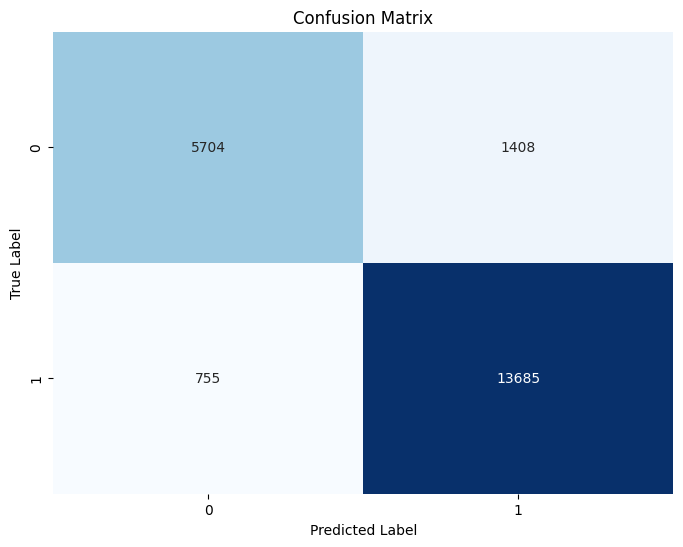

In [30]:
import numpy as np

# Assuming y_test is one-hot encoded
if y_test.shape[1] > 1:
    y_true = np.argmax(y_test.values, axis=1)
else:
    y_true = y_test.values  # Use the class labels directly

y_pred = np.argmax(model.predict(X_test), axis=1)

# Now proceed with the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig("confusion_matrix_lstm.png")  # Save plot locally

In [32]:
test_accuracy= accuracy_score(y_true, y_pred)
print(test_accuracy)

0.8996380846325167


In [33]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

# Log the test accuracy metric for the existing run
client.log_metric('f8b0e6e1aee14f4f89c1b68e3e56bfc8', 'test_accuracy', test_accuracy)